In [1]:
import sys
sys.path.append('../')

In [2]:
import pickle
import numpy as np
import pandas as po
from tqdm import tqdm
from math import isinf 
import multiprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import array, zeros, full, argmin, inf, ndim

In [3]:
from filepaths import fp

In [4]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [5]:
def dtw(x, y, dist, warp=1, w=inf, s=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    :param int w: window size limiting the maximal distance between indices of matched entries |i,j|.
    :param float s: weight applied on off-diagonal moves of the path. As s gets larger, the warping path is increasingly biased towards the diagonal
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(i, j, x, y)
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

In [6]:
def derivative_dtw_distance(i, j, x, y):
    if i+1 == len(x) or j+1 == len(y):
        dist = (x[i] - y[j])**2
    
    else:
        d_x_i = ((x[i] - x[i-1]) + (x[i+1] - x[i-1])/2)/2
        d_y_j = ((y[j] - y[j-1]) + (y[j+1] - y[j-1])/2)/2    

        dist = (d_x_i - d_y_j)**2

    return dist

In [7]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [8]:
def dtwbi(D, Q, len_gap, stride=20):
	
	min_dtw_cost = inf
	start_index = 0
	
	for i in range(0, len(D)-len_gap, stride):
		#print(i, i+len_gap)
		try:
			cost, cost_matrix, acc_cost_matrix, path = dtw(D[i:i+len_gap], Q, dist=derivative_dtw_distance)
		except:
			print(D[i*len_gap:(i+1)*len_gap])
			print('Q', Q)
			print('len_gap', len_gap)
			print('len(D)', len(D))
			print(i*len_gap, (i+1)*len_gap)
			raise
		if cost < min_dtw_cost:
			min_dtw_cost = cost
			start_index=i

	return start_index

In [9]:
def apply_dtwbi_after(x, start_index, end_index):
	len_gap = end_index - start_index
	
	Qa = x[end_index:end_index+len_gap]
	Da = x[end_index+len_gap:]
	
	Qas_start = dtwbi(Da, Qa, len_gap)
	#Qas = x[Qas_start:Qas_start+len_gap]
	
	if Qas_start-len_gap < 0:
		refA = x[Qas_start:Qas_start+len_gap] # = Qa
	else:
		refA = x[Qas_start-len_gap:Qas_start] # Previous window of Qas

	return refA

In [10]:
def apply_dtwbi_before(x, start_index, end_index):
	len_gap = end_index - start_index
	
	Qb = x[start_index-len_gap:start_index]
	Db = x[:start_index-len_gap]
	
	if len(Qb) == 0:
		print('start_index', start_index)
		print('len_gap', len_gap)
		print('end_index', end_index)
		raise

	Qbs_start = dtwbi(Db, Qb, len_gap)
	#Qbs = x[Qbs_start:Qbs_start+len_gap]
	
	if Qbs_start+2*len_gap > len(x):
		refB = x[Qbs_start:Qbs_start+len_gap] # = Qb
	
	else:
		refB = x[Qbs_start+len_gap:Qbs_start+2*len_gap] # Next window of Qbs

	return refB

In [11]:
def edtwbi(x, start_index, end_index):
	len_gap = end_index - start_index
	
	if end_index + len_gap >= len(x):
		refB = apply_dtwbi_before(x, start_index, end_index) # only dtwbi in other direction
		
		return refB
		
	elif start_index-len_gap <= 0:
		refA = apply_dtwbi_after(x, start_index, end_index) # only dtwbi in other direction
		
		return refA
	
	else: # both cannot simultaneously happen, so not keeping a case for that
		refA = apply_dtwbi_after(x, start_index, end_index)
		refB = apply_dtwbi_before(x, start_index, end_index)
		
		return np.mean([np.array(refA), np.array(refB)], axis = 0)

In [12]:
def impute_row(i):
	row = df.iloc[i][:-2].to_list()
	row_filled = row.copy()
	
	gaps = find_gaps(row)
	for gap in gaps:
		if gap[1] - gap[0] < 0.3*len(row):
			row_filled[gap[0]:gap[1]] = edtwbi(row, gap[0], gap[1])

	return row_filled

In [13]:
#new_rows = list(tqdm(map(impute_row, list(range(len(df)))), total=len(df))) 

In [14]:
# Non-MP version
#new_rows = list(map(impute_row, list(range(2))))#list(range(len(df)))) 

In [15]:
df = po.read_csv('../data/processed/imputation/imp_raw.csv')

In [18]:
p = multiprocessing.Pool() 
new_rows = list(tqdm(p.imap(impute_row, list(range(len(df)))), total=len(df)))

100%|██████████| 24272/24272 [38:29<00:00, 10.51it/s]


In [19]:
df_edtwbi_impute = po.DataFrame(new_rows)

In [20]:
df_edtwbi_impute.columns = df.columns[:-2]

In [21]:
df_edtwbi_impute

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
0,0.003306,0.005092,0.004084,0.002153,0.002118,0.002233,0.002193,0.002183,0.002754,0.002912,...,0.001007,0.000905,0.000711,0.000954,0.000763,0.000935,0.000706,0.000838,0.001079,0.001154
1,0.002839,0.002636,0.001719,0.000802,0.001172,0.001789,0.001347,0.001796,0.001463,0.001856,...,0.000434,0.000277,0.000536,0.000574,0.000536,0.000528,0.000357,0.000219,0.000523,0.000632
2,0.001043,0.001152,0.001260,0.000765,0.001356,0.001947,0.001788,0.002352,0.001590,0.002390,...,0.000379,0.000532,0.000389,0.000409,0.000522,0.000340,0.000028,0.000030,0.000123,0.000136
3,0.003647,0.004900,0.003473,0.002046,0.002234,0.002423,0.002611,0.004230,0.006640,0.008113,...,0.001479,0.001695,0.000921,0.000646,0.001120,0.000639,0.000595,0.000465,0.000907,0.000368
4,0.004756,0.004716,0.004660,0.002529,0.002707,0.003427,0.002706,0.003627,0.002892,0.003371,...,0.000977,0.001023,0.000833,0.001026,0.000962,0.000762,0.000782,0.000791,0.000898,0.001173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24267,0.002694,0.002704,0.003149,0.001000,0.001347,0.001487,0.001405,0.002146,0.001875,0.001775,...,0.000548,0.000742,0.000437,0.000709,0.000591,0.000555,0.000415,0.000524,0.000627,0.000546
24268,0.000648,0.000892,0.000438,0.000416,0.000146,0.000177,0.000132,0.000161,0.000161,0.000514,...,0.000143,0.000141,0.000110,0.000206,0.000345,0.000106,0.000132,0.000133,0.000124,0.000172
24269,0.000073,0.000077,0.000051,0.000061,0.000089,0.000061,0.000043,0.000073,0.000014,0.000009,...,0.000389,0.000405,0.000338,0.000378,0.000241,0.000302,0.000230,0.000325,0.000367,0.000459
24270,0.000630,0.001240,0.001197,0.000547,0.000635,0.000717,0.000724,0.000964,0.000711,0.000819,...,0.000289,0.000482,0.000298,0.000466,0.000352,0.000280,0.000278,0.000308,0.000280,0.000481


In [22]:
num_zeros = []
for i in tqdm(range(len(df_edtwbi_impute))):
    num_zeros.append(df_edtwbi_impute.iloc[i].to_list().count(0))

100%|██████████| 24272/24272 [00:02<00:00, 9602.58it/s]


In [23]:
df_edtwbi_impute['num_zeros'] = num_zeros

In [24]:
df['num_zeros']

0          0
1        160
2          0
3        106
4          0
        ... 
24267      0
24268      0
24269    199
24270      0
24271      2
Name: num_zeros, Length: 24272, dtype: int64

In [25]:
df_edtwbi_impute['num_zeros']

0        0
1        0
2        0
3        0
4        0
        ..
24267    0
24268    0
24269    7
24270    0
24271    0
Name: num_zeros, Length: 24272, dtype: int64

In [26]:
df_edtwbi_impute['FLAG'] = df['FLAG']

In [54]:
df_edtwbi_impute

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31,num_zeros,FLAG
0,0.003306,0.005092,0.004084,0.002153,0.002118,0.002233,0.002193,0.002183,0.002754,0.002912,...,0.000711,0.000954,0.000763,0.000935,0.000706,0.000838,0.001079,0.001154,0,0
1,0.002839,0.002636,0.001719,0.000802,0.001172,0.001789,0.001347,0.001796,0.001463,0.001856,...,0.000536,0.000574,0.000536,0.000528,0.000357,0.000219,0.000523,0.000632,0,0
2,0.001043,0.001152,0.001260,0.000765,0.001356,0.001947,0.001788,0.002352,0.001590,0.002390,...,0.000389,0.000409,0.000522,0.000340,0.000028,0.000030,0.000123,0.000136,0,0
3,0.003647,0.004900,0.003473,0.002046,0.002234,0.002423,0.002611,0.004230,0.006640,0.008113,...,0.000921,0.000646,0.001120,0.000639,0.000595,0.000465,0.000907,0.000368,0,0
4,0.004756,0.004716,0.004660,0.002529,0.002707,0.003427,0.002706,0.003627,0.002892,0.003371,...,0.000833,0.001026,0.000962,0.000762,0.000782,0.000791,0.000898,0.001173,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24267,0.002694,0.002704,0.003149,0.001000,0.001347,0.001487,0.001405,0.002146,0.001875,0.001775,...,0.000437,0.000709,0.000591,0.000555,0.000415,0.000524,0.000627,0.000546,0,0
24268,0.000648,0.000892,0.000438,0.000416,0.000146,0.000177,0.000132,0.000161,0.000161,0.000514,...,0.000110,0.000206,0.000345,0.000106,0.000132,0.000133,0.000124,0.000172,0,1
24269,0.000073,0.000077,0.000051,0.000061,0.000089,0.000061,0.000043,0.000073,0.000014,0.000009,...,0.000338,0.000378,0.000241,0.000302,0.000230,0.000325,0.000367,0.000459,7,0
24270,0.000630,0.001240,0.001197,0.000547,0.000635,0.000717,0.000724,0.000964,0.000711,0.000819,...,0.000298,0.000466,0.000352,0.000280,0.000278,0.000308,0.000280,0.000481,0,0


In [53]:
df_edtwbi_impute.to_csv('../data/processed/imputation/edtwbi.csv', index=False)

In [28]:
i = 1212

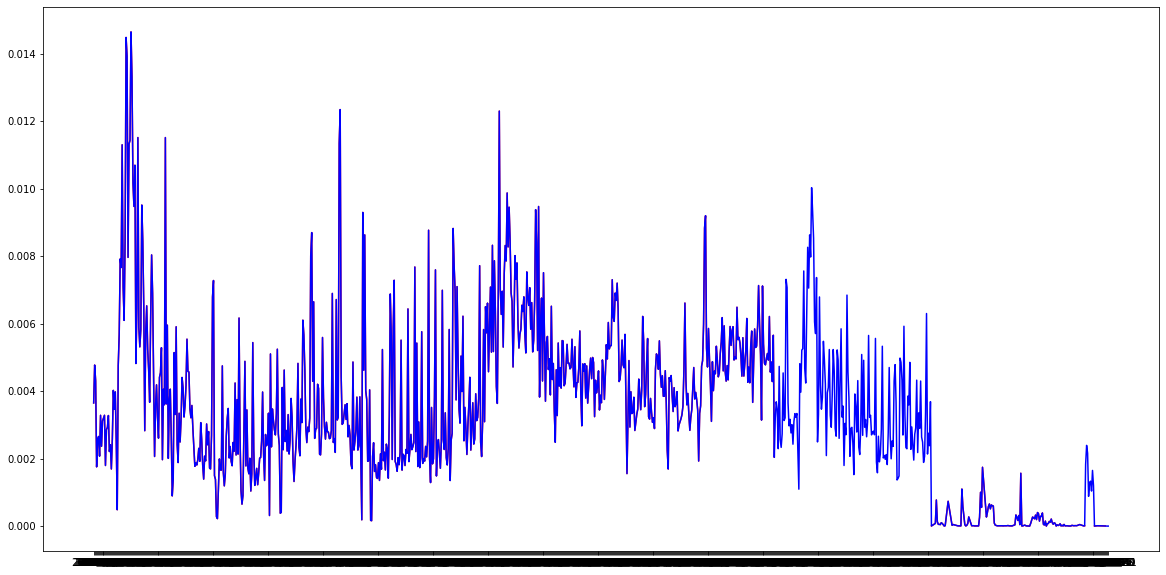

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[i][:-2], color='red')
plt.plot(df_edtwbi_impute.iloc[i][:-2], color='blue')

In [4]:
#df_edtwbi_impute = po.read_csv('../' + fp.edtwbi_imputed_df)

In [5]:
#df = po.read_csv('../'+fp.imputation_raw)

In [32]:
df[df==0]=None

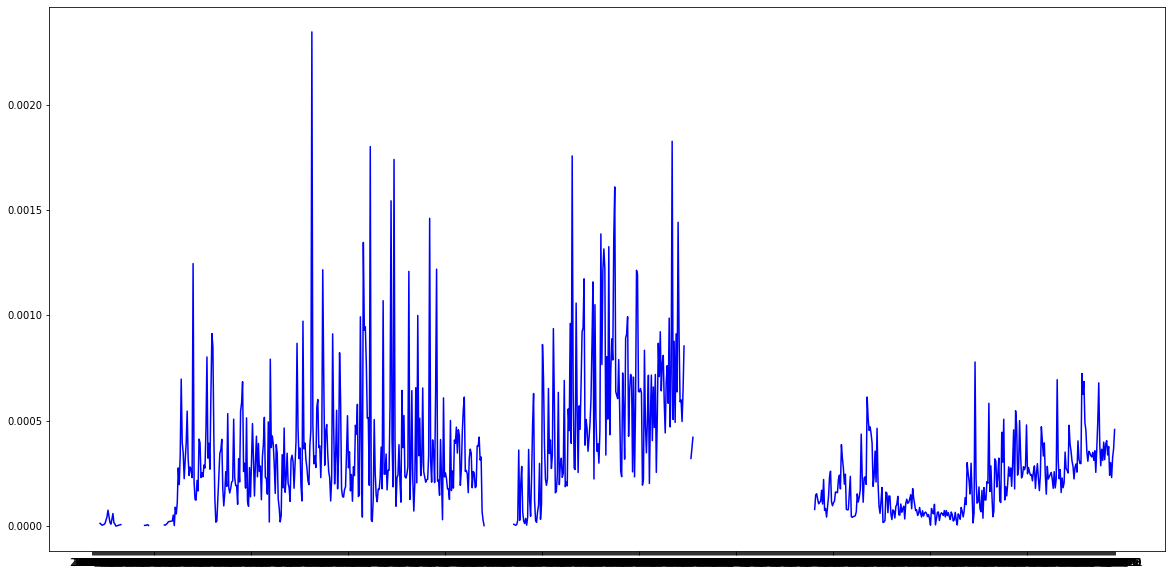

In [46]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[24269][:-2], color='Blue')

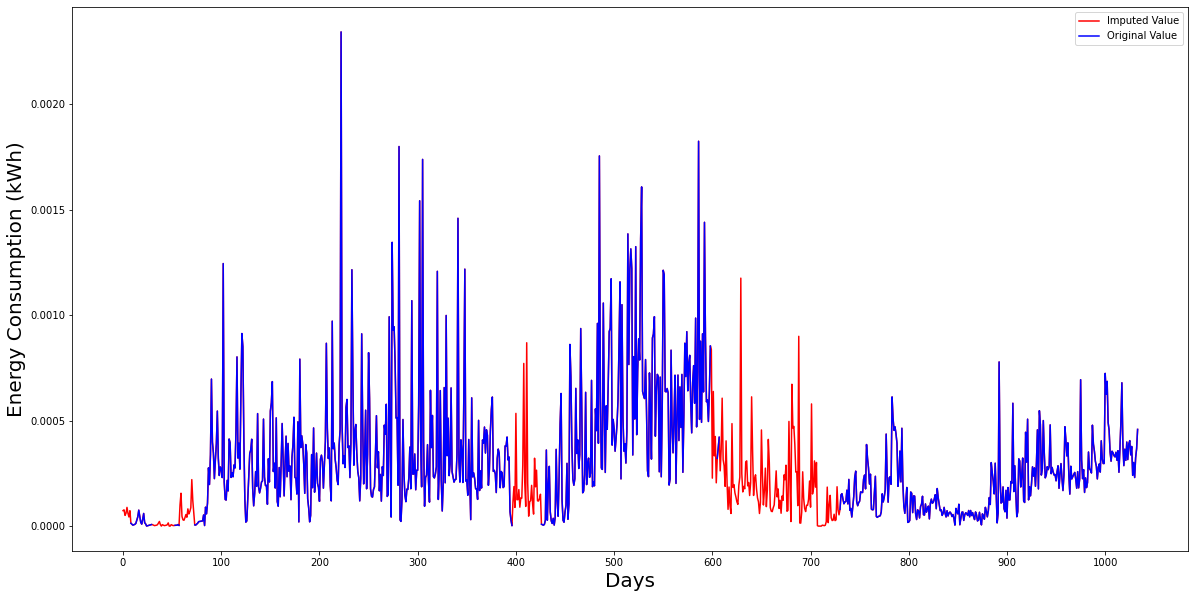

In [52]:
plt.figure(figsize=(20, 10))
plt.plot(df_edtwbi_impute.iloc[24269][:-2], color='red')
plt.plot(df.iloc[24269][:-2], color='Blue')
plt.xticks(range(0, len(df.iloc[28][:-2]), 100), range(0, len(df.iloc[24269][:-2]), 100)) 
plt.xlabel('Days', fontsize=20)
plt.ylabel('Energy Consumption (kWh)', fontsize=20)
plt.legend(['Imputed Value', 'Original Value'])
plt.savefig('../plots/impute/eDTWBI.png')